In [3]:
import torch
from torchvision import datasets, transforms
# from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as  np
from torchvision import utils
import matplotlib.pyplot as plt
import os

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
path='dataset/Train_dataset_new'
n_channels = 3
n_classes = 10
batch_size = 64
learning_rate = 0.001
transform = transforms.Compose([
#             transforms.RandomResizedCrop(224),
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [6]:
dataset = datasets.ImageFolder(root=path, transform=transform)

# Split the dataset into train, test and validation.
total_dataset_len = len(dataset)
train_dataset_len = int(0.7 * total_dataset_len)
val_dataset_len = int(0.15 * total_dataset_len)
test_dataset_len = total_dataset_len - train_dataset_len - val_dataset_len
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_dataset_len, val_dataset_len, test_dataset_len])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=2, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, num_workers=2, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, num_workers=2, shuffle=False)
print(len(train_loader))

532


In [7]:
dataset.classes

['airport_terminal',
 'auditorium',
 'bedroom',
 'bookstore',
 'bus_station-indoor',
 'clothing_store',
 'computer_room',
 'food_court',
 'jewelry_shop',
 'railroad_track']

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class VGG13(nn.Module):
    def __init__(self, num_classes):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
model = VGG13(10)

In [10]:
model = model.to(device)

In [11]:
print(model)

VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, n_epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = (train_correct / train_total) * 100
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        if scheduler:
            scheduler.step()

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = (val_correct / val_total) * 100
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        if val_acc > 85:
            savePath = f"/user/paragsha/{epoch+1}.pth"
            torch.save(model.state_dict(), 'vgg_final_project_50.pth')
            

    return train_losses, train_accs, val_losses, val_accs

In [13]:
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [14]:
train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer,scheduler, 70)

Epoch 1/70:
Train Loss: 1.6800, Train Acc: 41.7095
Val Loss: 1.5307, Val Acc: 46.7910
Epoch 2/70:
Train Loss: 1.2001, Train Acc: 59.9477
Val Loss: 1.0699, Val Acc: 63.5628
Epoch 3/70:
Train Loss: 0.9775, Train Acc: 67.5727
Val Loss: 0.8617, Val Acc: 71.5579
Epoch 4/70:
Train Loss: 0.8608, Train Acc: 71.7656
Val Loss: 0.8499, Val Acc: 71.9007
Epoch 5/70:
Train Loss: 0.7677, Train Acc: 74.6041
Val Loss: 0.8507, Val Acc: 71.4070
Epoch 6/70:
Train Loss: 0.7091, Train Acc: 76.4581
Val Loss: 0.7390, Val Acc: 74.8080
Epoch 7/70:
Train Loss: 0.6445, Train Acc: 78.8793
Val Loss: 0.7816, Val Acc: 73.5189
Epoch 8/70:
Train Loss: 0.6087, Train Acc: 80.0929
Val Loss: 0.7202, Val Acc: 76.9062
Epoch 9/70:
Train Loss: 0.5660, Train Acc: 81.1859
Val Loss: 0.7664, Val Acc: 75.1234
Epoch 10/70:
Train Loss: 0.5367, Train Acc: 82.1938
Val Loss: 0.6600, Val Acc: 78.9358
Epoch 11/70:
Train Loss: 0.5026, Train Acc: 83.4660
Val Loss: 0.6823, Val Acc: 77.1805
Epoch 12/70:
Train Loss: 0.4740, Train Acc: 83.9597


In [15]:
torch.save(model.state_dict(), 'vgg_final_project_70.pth')

In [16]:
def eval_model(model, data_loader, type='validation'):
  correct=0
  total=0
  running_loss = 0.0
  with torch.no_grad():
    model.eval()
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)  
      pred = model(inputs)
      total += labels.size(0)
      loss = criterion(pred, labels.squeeze().long())
      running_loss += loss.item()
      _, predicted = torch.max(pred.data, 1)
      correct += predicted.eq(labels.squeeze().long()).sum().item()
    # print(f'Accuracy of {type},  {100 * correct // total} %')
  test_val_loss = running_loss / len(data_loader)
  test_val_accuracy = 100 * correct / total
  return test_val_loss, test_val_accuracy

In [17]:
test_loss, test_accuracy = eval_model(model, test_loader, type='testing')
print(test_loss, test_accuracy)

0.9978317309889877 85.3852481491637


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_curve, auc
import seaborn as sns

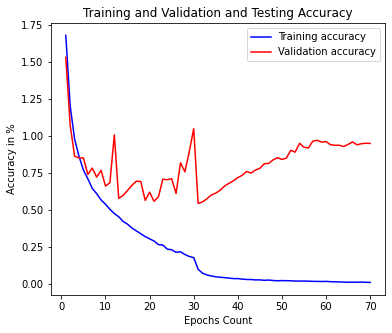

In [19]:
# Plot the training and validation Loss over time (epochs)
num_of_epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(6, 5))
plt.plot(num_of_epochs, train_losses, 'b', label='Training accuracy')
plt.plot(num_of_epochs, val_losses, 'r', label='Validation accuracy')
# plt.plot(num_of_epochs, test_accuracy_arr, 'g', label='Testing accuracy')
plt.title('Training and Validation and Testing Accuracy')
plt.xlabel('Epochs Count')
plt.ylabel('Accuracy in %')
plt.legend()
plt.show()

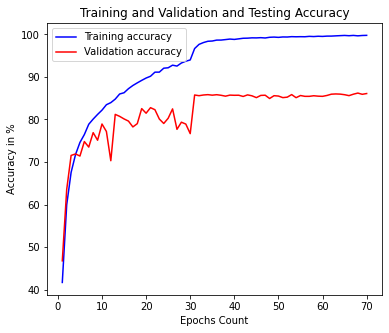

In [20]:
# Plot the training and validation accuracy over time (epochs)
num_of_epochs = range(1, len(train_accs) + 1)
plt.figure(figsize=(6, 5))
plt.plot(num_of_epochs, train_accs, 'b', label='Training accuracy')
plt.plot(num_of_epochs, val_accs, 'r', label='Validation accuracy')
# plt.plot(num_of_epochs, test_accuracy_arr, 'g', label='Testing accuracy')
plt.title('Training and Validation and Testing Accuracy')
plt.xlabel('Epochs Count')
plt.ylabel('Accuracy in %')
plt.legend()
plt.show()

In [21]:
y_pred = []
y_pred_softmax = []
y_true = []
y_labels = []
model.eval()
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    pred = model(inputs)
    _, predicted = torch.max(pred.data, 1)
    probs = F.softmax(pred, dim=1)

    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.squeeze().cpu().numpy())
    y_pred_softmax.append(probs.cpu())  
    y_labels.append(labels)

# Confusion metric
y_pred_softmax = torch.cat(y_pred_softmax, dim=0)
y_labels = torch.cat(y_labels, dim=0)
confusionMatrix = confusion_matrix(y_true, y_pred)


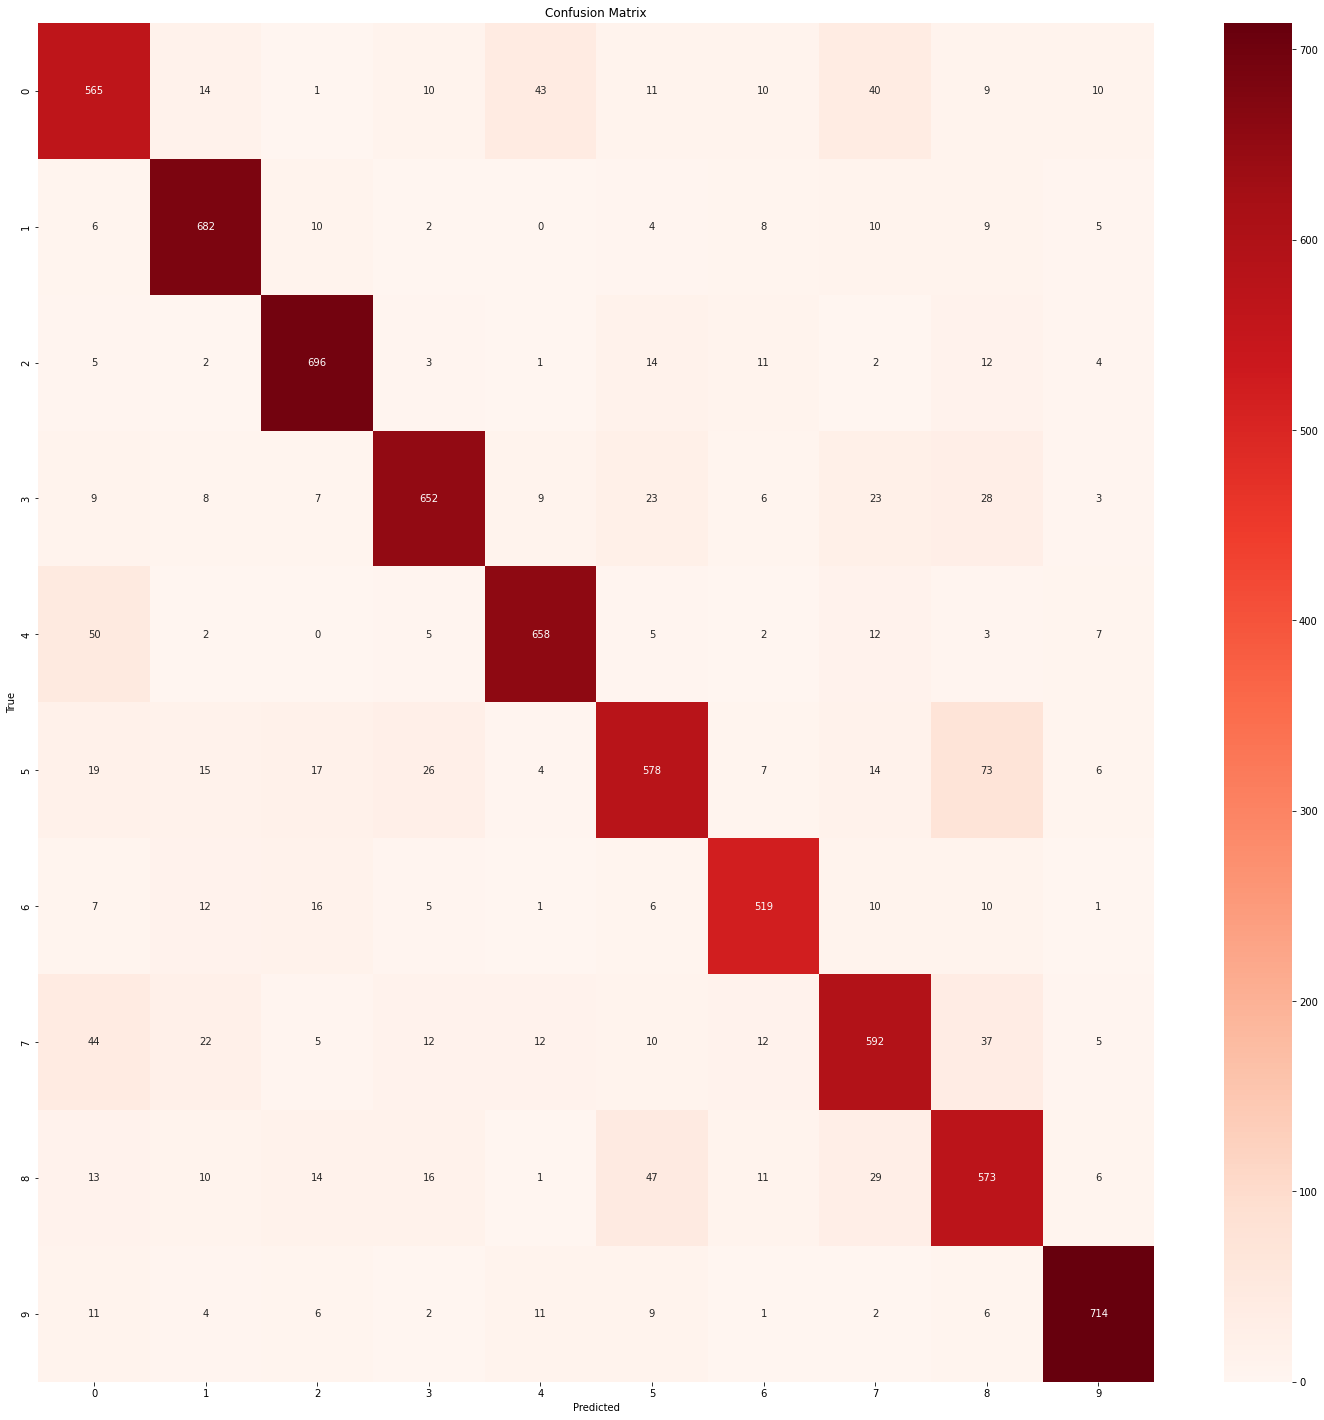

In [22]:
# Generate confusion Matrix using heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Print precision, recall, f1_score using scikit learn
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1_score:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Precision: 0.85
Recall: 0.85
F1-score: 0.85
Accuracy: 0.85
